파인튜닝 - MobileNet <br>
모델 전체 (또는 대부분의  layer) 대한 가중치 학습(조정)

In [42]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
import math
import numpy as np

In [43]:
# from google.colab import drive
# drive.mount('/content/drive')

In [44]:
# 학습, 검증, 테스트 데이터셋의 경로를 설정
TRAIN_DATA_DIR = 'data/imgs/data_mw_train/'
TEST_DATA_DIR = 'data/imgs/data_mw_test/'
VALIDATION_DATA_DIR = 'data/imgs/data_mw_valid/'


# 학습, 검증, 분류할 클래스, 이미지 크기, 배치 크기 설정
TRAIN_SAMPLES = 200*20
VALIDATION_SAMPLES = 10*20
NUM_CLASSES = 2
IMG_WIDTH, IMG_HEIGHT = 224, 224 # image size for MobileNet
BATCH_SIZE = 64 # 64

ImageDataGenerator 클래스를 사용해서 data augmentation <br>
학습데이터 augmentation<br>
(평가데이터, 검증데이터는 증강 x)

In [45]:
# 학습 데이터에 대해서는 데이터 증강 적용 -> 모델의 일반화 성능 향상
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, # 입력 포맷팅, normalization(픽셀 값 조정)
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2, # 최대 20%까지 무작위 확대
                                   horizontal_flip=True,
                                   vertical_flip=True)

# 검증 데이터에는 증강 적용 X
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, # 입력 포맷팅, normalization(픽셀 값 조정)
                                   rotation_range=0,
                                   width_shift_range=0,
                                   height_shift_range=0,
                                   zoom_range=0, # 최대 20%까지 무작위 확대
                                   horizontal_flip=False,
                                   vertical_flip=False)
  # 다른 옵션 없음, 증대 변환을 적용 X -> 실제 검증 환경의 예상 형식 및 분포와 최대한 유사하게 데이터에 대한 모델 평가


In [46]:
# 학습 및 검증 데이터 제너레이터를 설정
# train_datagen을 사용해서 학습 데이터 호출, 모델에 제공
# data augmentation -> 이미지 배치가 에포크마다 모델에 공급
# train_generator는 학습 동안 모델에 데이터를 제공하는 역할을 합니다. train_datagen에 의해 지정된 데이터 증강과
train_generator = train_datagen.flow_from_directory(TRAIN_DATA_DIR, # 학습 이미지가 저장된 디렉토리의 경로입니다. 이 경로 내의 폴더 구조는 각 클래스별로 분류되어 있어야 하며, 각 클래스 폴더 내에 해당 클래스의 이미지들이 들어 있습니다.
                                                    target_size=(IMG_WIDTH,  # 모델에 입력될 이미지의 크기 설정, MobileNet 224x224
                                                                 IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    seed=12345, # 데이터 randomness...
                                                    class_mode='categorical') # 레이블을 원-핫 인코딩 형태로 변환


Found 317 images belonging to 2 classes.


In [47]:
validation_generator = val_datagen.flow_from_directory(VALIDATION_DATA_DIR, # 학습 이미지가 저장된 디렉토리의 경로입니다. 이 경로 내의 폴더 구조는 각 클래스별로 분류되어 있어야 하며, 각 클래스 폴더 내에 해당 클래스의 이미지들이 들어 있습니다.
                                                    target_size=(IMG_WIDTH,  # 모델에 입력될 이미지의 크기 설정, MobileNet 224x224
                                                                 IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    seed=12345, # 데이터 randomness...
                                                    class_mode='categorical') # 레이블을 원-핫 인코딩 형태로 변환

Found 26 images belonging to 2 classes.


새로운 모형 구축

In [48]:
# Functional
# MobileNet을 기반으로 사용자 정의 모델 구축
# 모든 레이어의 학습 가능 여부를 False로 설정 -< 가중치를 고정
def model_maker():
    # top 층을 제외한 사전학습 모형 호출
    base_model = MobileNet(include_top=False,
                           input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    for layer in base_model.layers[:]:
        layer.trainable = False
    for layer in base_model.layers[-30:]:
        layer.trainable = True # 학습 과정에서 이 레이어들의 가중치 업데이트 X -> 학습된 가중치 값 유지

    input1 = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    custom_model = base_model(input1)
    custom_model = GlobalAveragePooling2D()(custom_model) # 각 채널 (7x7 채널)에서 평균값 하나만 추출
        # 기본 네트워크의 출력 feature 맵의 차원(높이 및 너비)을  줄임
    custom_model = Dense(64, activation='relu')(custom_model)
    predictions = Dense(NUM_CLASSES, activation='softmax')(custom_model)
        # 출력 층, NUM_CLASSES : 예측 클래스 수 = 2
    return Model(inputs=input1, outputs=predictions)

In [49]:
model_final = model_maker()

In [50]:
model_final.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_3   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 64)                65600     
                                                                 
 dense_7 (Dense)             (None, 2)                 130       
                                                                 
Total params: 3,294,594
Trainable params: 2,461,378
Non-tra

In [51]:
# 손실 함수, 최적화 알고리즘, 평가 지표 설정
model_final.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=['acc'])


In [52]:
# 모델을 컴파일, 학습 수행
history = model_final.fit(
    train_generator, # 학습데이터 호출
    steps_per_epoch=5, # number of updates, 1 epoch 당 업데이트 횟수 지정
    epochs=20, # 20,
    validation_data=validation_generator,) # 검증 데이터 호출)

Epoch 1/20
5/5 [==============================] - 20s 4s/step - loss: 0.9434 - acc: 0.5457 - val_loss: 1.2670 - val_acc: 0.5385
Epoch 2/20
5/5 [==============================] - 17s 3s/step - loss: 0.5626 - acc: 0.7129 - val_loss: 0.9856 - val_acc: 0.5769
Epoch 3/20
5/5 [==============================] - 17s 3s/step - loss: 0.4711 - acc: 0.7792 - val_loss: 1.0115 - val_acc: 0.6154
Epoch 4/20
5/5 [==============================] - 17s 4s/step - loss: 0.3757 - acc: 0.8707 - val_loss: 1.0649 - val_acc: 0.6538
Epoch 5/20
5/5 [==============================] - 17s 4s/step - loss: 0.3202 - acc: 0.8738 - val_loss: 1.0926 - val_acc: 0.6538
Epoch 6/20
5/5 [==============================] - 17s 3s/step - loss: 0.2751 - acc: 0.9085 - val_loss: 1.0812 - val_acc: 0.6538
Epoch 7/20
5/5 [==============================] - 17s 3s/step - loss: 0.2118 - acc: 0.9401 - val_loss: 1.0360 - val_acc: 0.6538
Epoch 8/20
1/5 [=====>........................] - ETA: 13s - loss: 0.1850 - acc: 0.9531

KeyboardInterrupt: 

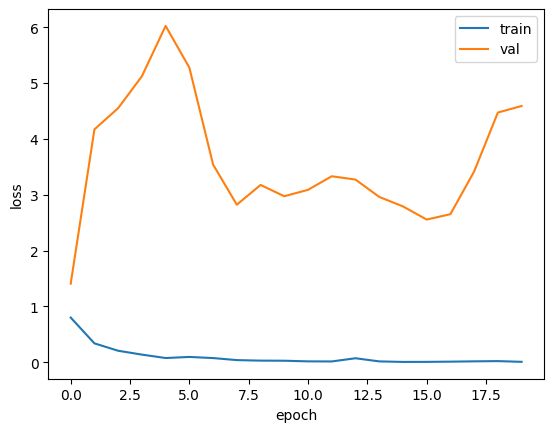

In [53]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

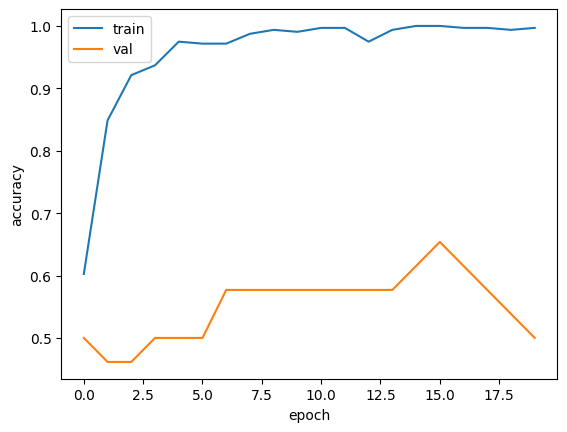

In [54]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','val'])
plt.show()

In [55]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [56]:
test_generator = test_datagen.flow_from_directory(
    TEST_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=400,
    shuffle=False,
    class_mode='categorical')

Found 20 images belonging to 2 classes.


In [57]:
model_final.evaluate(test_generator,verbose=0)

[0.3843834698200226, 0.8500000238418579]

In [58]:
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt

1/1 [==============================] - 0s 358ms/step
[0.0309163 0.9690837]


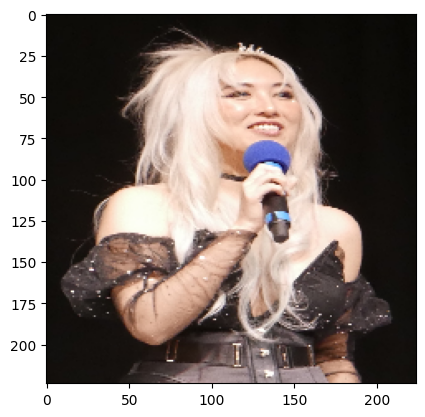

In [59]:
img_path = "E:\KDT\KDT__season_3\data\imgs\data_mw_valid\woman\w_183.jpg"
# img_path = '/content/ss.JPG'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
plt.imshow(img_array/255)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = expanded_img_array / 255

prediction = model_final.predict(preprocessed_img)
print(np.array(prediction[0]))

1/1 [==============================] - 0s 19ms/step
[0.8092747  0.19072531]


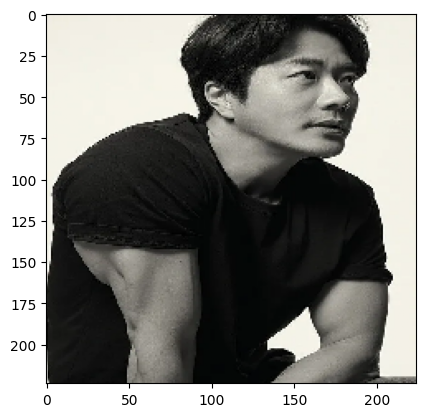

In [60]:
img_path = 'data\_test_12.png'
# img_path = '/content/ss.JPG'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
plt.imshow(img_array/255)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = expanded_img_array / 255

prediction = model_final.predict(preprocessed_img)
print(np.array(prediction[0]))

1/1 [==============================] - 0s 22ms/step
[0.3903294  0.60967064]


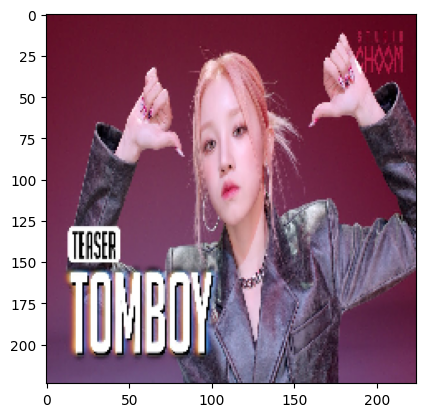

In [66]:
img_path = 'data/_test_13.png'
# img_path = '/content/ss.JPG'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
plt.imshow(img_array/255)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = expanded_img_array / 255

prediction = model_final.predict(preprocessed_img)
print(np.array(prediction[0]))

1/1 [==============================] - 0s 17ms/step
[0.1494407 0.8505593]


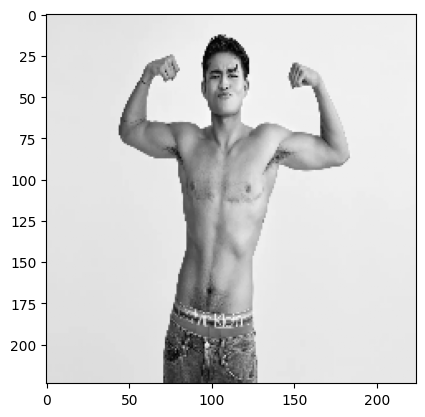

In [68]:
img_path = 'data/_test_15.png'
# img_path = '/content/ss.JPG'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
plt.imshow(img_array/255)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = expanded_img_array / 255

prediction = model_final.predict(preprocessed_img)
print(np.array(prediction[0]))

In [62]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

def model_maker():
    base_model = MobileNet(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
    for layer in base_model.layers:
        layer.trainable = False  # Freeze the layers

    input1 = Input(shape=(224, 224, 3))
    custom_model = base_model(input1)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model = Dense(64, activation='relu')(custom_model)
    predictions = Dense(2, activation='softmax')(custom_model)  # Assuming 2 classes

    return Model(inputs=input1, outputs=predictions)

# Create the model
model_final = model_maker()

# Print the model summary
model_final.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_4   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 64)                65600     
                                                                 
 dense_9 (Dense)             (None, 2)                 130       
                                                                 
Total params: 3,294,594
Trainable params: 65,730
Non-traina

In [63]:
model_final.layers[1].summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         